# LogitBoost Algorithm
## Purpose 
According to the paper, this algorithm is for fitting *additive logistic regression models* by maximum likelihood, uses the Newton-like steps to optimise the
loss criterion.

LogitBoost is a boosting algorithm used for improving the accuracy of classification models. It is an adaptation of the AdaBoost algorithm, designed specifically to work well with logistic regression models, although it can be applied to other types of predictive models as well.  

The LogitBoost algorithm minimizes the logistic loss: $\sum_i log(1+e^{-y_i f(x_i)})$.  

We then go on to derive a new boosting procedure “LogitBoost” that directly optimizes the binomial log-likelihood.



## For two clases
### Algorithm steps
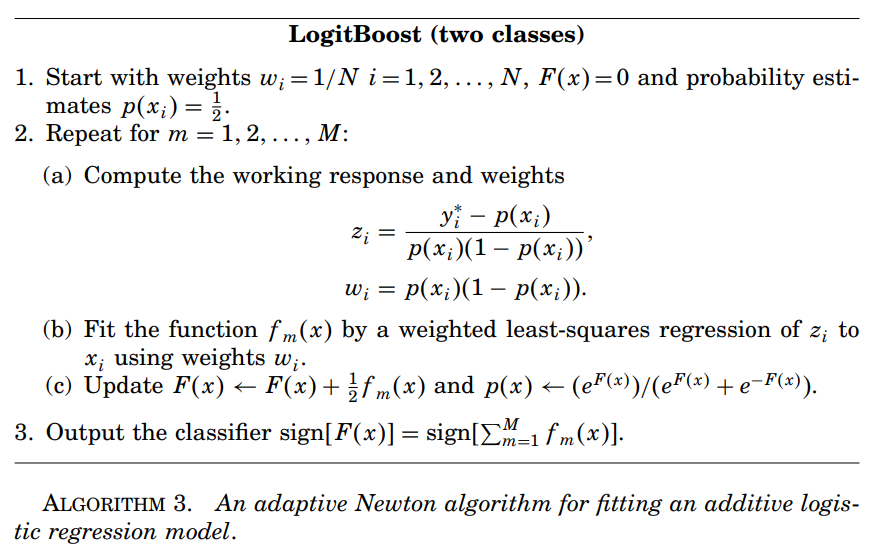

The LogitBoost algorithm (two classes, population version) uses Newton steps for fitting an additive symmetric logistic model by maximum likelihood.

In [1]:
# Libraries
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.datasets import make_circles
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score, log_loss

For this example, it is going to be use two datasets for the classification task, one with a linear decision border and the other one with a non linear decision border.

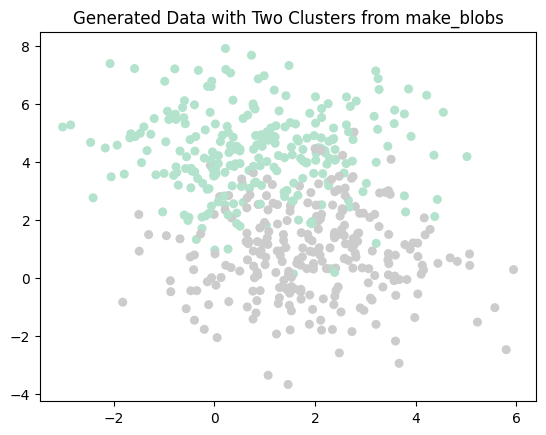

Shape of X: (500, 2)
Shape of y: (500,)


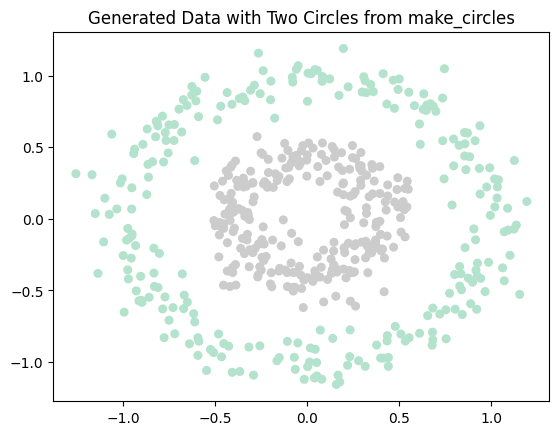

Shape of X2: (500, 2)
Shape of y2: (500,)


In [2]:
# Generate synthetic data using make_blobs
X1,y1 = make_blobs(n_samples=500, centers=2, cluster_std=1.5, random_state=0)
plt.scatter(X1[:, 0], X1[:, 1], s=30, c=y1, cmap=plt.cm.Pastel2)
plt.title("Generated Data with Two Clusters from make_blobs")
plt.show()

print("Shape of X:", X1.shape)
print("Shape of y:", y1.shape)

# Generate synthetic data using make_circles
X2, y2 = make_circles(n_samples=500, noise=0.1, factor=0.4, random_state=0)
plt.scatter(X2[:, 0], X2[:, 1], s=30, c=y2, cmap=plt.cm.Pastel2)    
plt.title("Generated Data with Two Circles from make_circles")
plt.show()

print("Shape of X2:", X2.shape)
print("Shape of y2:", y2.shape)

According to the original Logistic Model Trees of 2005 by Landhwehr, the functions in $f_m$ are **simple (linear) regression (one attribute) functions fitted by least squares as the error criterion**. So for this two classes example, where are going to use those ones as the *weak learners*. Also, the maximum number of iterations is going to be set at $500$ in order to replicate the parameters of the paper.

In [14]:
def logitboost_fit(X, y, n_estimators=500, eps=1e-5):
    """
    Function to fit a LogitBoost model.
    Parameters
    X : array (n_samples, n_features)
    y : {0,1} labels
    n_estimators : int, number of boosting iterations
    eps : lower/upper bound for p so that p∈[eps, 1-eps]

    Returns
    learners : list of tuples (feat_idx, b0, b1) with len = n_estimators.
        Each tuple represents a linear regressor fitted to the working response.
        The first element is the feature index, the second is the intercept (b0),
        and the third is the slope (b1) of the linear regressor.
    """
    # Data validation and conversion
    X = np.asarray(X, float)
    y = np.asarray(y, int).ravel()
    N, p_dim = X.shape

    # Step 1: Initialization
    F  = np.zeros(N) # F(x) = 0
    w = np.full(N, 1.0 / N) # initial weights  w_i = 1/N 
    p  = np.full(N, 0.5) # initial probabilities p_i = 1/2
    learners = []

    # Step 2: Iterative boosting
    for m in range(n_estimators):
        # Step 2 (a): working response & weights
        w = p * (1.0 - p) # w_i = p_i(1-p_i)      
        w = np.clip(w, eps, None) # numerical safety
        z = (y - p) / w # z_i =(y_i* – p_i)/(p_i(1-p_i))

        # Step 2 (b): best 1-D weighted LS regressor, Fit the function fm(x) by a weighted least-squares regression of zi to xi using weights wi.
        best_err = np.inf
        for j in range(p_dim):
            lr = LinearRegression()
            lr.fit(X[:, [j]], z, sample_weight=w)
            f_hat = lr.predict(X[:, [j]])
            err   = np.sum(w * (z - f_hat) ** 2)   # weighted sum of squared-errors

            if err < best_err:
                best_err   = err
                best_model = (j, lr.intercept_, lr.coef_[0])
                best_f_hat = f_hat

        feat_idx, b0, b1 = best_model
        learners.append(best_model)

        # Step 2 (c): update F(x)  and  p(x)
        F += 0.5 * best_f_hat  # F ← F + ½ f_m(x)
        p  = np.clip(np.exp(F) / (np.exp(F) + np.exp(-F)), eps, 1.0 - eps)  # p(x) ← σ(F)

    return learners

In [15]:
learners = logitboost_fit(X1, y1,
                          n_estimators=500,
                          eps=1e-5)        # numerical safety

# Check of the first few weak learners
for k, (j, b0, b1) in enumerate(learners[:10], 1):
    print(f"L{k}: feature {j}  b0={b0:.4f}  b1={b1:.4f}")


L1: feature 1  b0=1.6947  b1=-0.6625
L2: feature 1  b0=1.0889  b1=-0.4179
L3: feature 0  b0=-0.5618  b1=0.4108
L4: feature 1  b0=0.7248  b1=-0.2771
L5: feature 0  b0=-0.1463  b1=0.1051
L6: feature 1  b0=0.2899  b1=-0.1101
L7: feature 0  b0=-0.0309  b1=0.0221
L8: feature 1  b0=0.0427  b1=-0.0162
L9: feature 0  b0=-0.0043  b1=0.0031
L10: feature 1  b0=0.0024  b1=-0.0009


In [16]:
def logitboost_predict(X, learners, return_proba=False):
    """
    Function to predict class labels for new data.
    Parameters
    X : array (n_samples, n_features)
    learners : list returned by `logitboost_fit`
    return_proba : bool, default False, if True also return P(y=1|x).

    Returns
    y_pred : ndarray (n_samples,)
    p_pred : ndarray (n_samples,)   -- only when `return_proba=True`
    """
    # Data validation and conversion
    X = np.asarray(X, dtype=float)
    F = np.zeros(X.shape[0])

    # Compute the linear combination of weak learners
    for feat_idx, b0, b1 in learners:
        F += 0.5 * (b0 + b1 * X[:, feat_idx])

    # Compute probabilities and class predictions
    if return_proba:
        p_pred = np.exp(F) / (np.exp(F) + np.exp(-F)) # p(x) = σ(F)
        return (F >= 0).astype(int), p_pred
    else:
        return (F >= 0).astype(int)

In [17]:
# Applied examples

# Predicting on the first dataset
X_train1, X_test1, y_train1, y_test1 = train_test_split(X1, y1, test_size=0.3, random_state=42, stratify=y1)
learners1 = logitboost_fit(X_train1, y_train1, n_estimators=500)
y1_pred, y1_proba = logitboost_predict(X_test1, learners1, return_proba=True)
# Evaluate the model
accuracy = accuracy_score(y_test1, y1_pred)
roc_auc = roc_auc_score(y_test1, y1_proba)
print(f"Accuracy on make_blobs: {accuracy:.4f}")
print(f"ROC AUC on make_blobs: {roc_auc:.4f}")



# Predicting on the second dataset
X_train2, X_test2, y_train2, y_test2 = train_test_split(X2, y2, test_size=0.3, random_state=42, stratify=y2)
learners2 = logitboost_fit(X_train2, y_train2, n_estimators=500)
y2_pred, y2_proba = logitboost_predict(X_test2, learners2, return_proba=True)
# Evaluate the model
accuracy2 = accuracy_score(y_test2, y2_pred)
roc_auc2 = roc_auc_score(y_test2, y2_proba)
print(f"Accuracy on make_circles: {accuracy2:.4f}")
print(f"ROC AUC on make_circles: {roc_auc2:.4f}")


Accuracy on make_blobs: 0.8800
ROC AUC on make_blobs: 0.9436
Accuracy on make_circles: 0.4267
ROC AUC on make_circles: 0.4327


In [18]:
# Sum of the two features of X2 squared
X2_squared_sum = np.sum(X2**2, axis=1)
X2_squared_sum = X2_squared_sum.reshape(-1, 1)
X2_squared_sum

# Add that column to the original dataset
X2_extended = np.hstack((X2, X2_squared_sum))

# Separate the extended dataset into training and testing sets
X_train2_ext, X_test2_ext, y_train2_ext, y_test2_ext = train_test_split(X2_extended, y2, test_size=0.3, random_state=42, stratify=y2)

# Fit the LogitBoost model on the extended dataset
learners2_ext = logitboost_fit(X_train2_ext, y_train2_ext, n_estimators=500)
y2_pred_ext, y2_proba_ext = logitboost_predict(X_test2_ext, learners2_ext, return_proba=True)
# Evaluate the extended model
accuracy2_ext = accuracy_score(y_test2_ext, y2_pred_ext)
roc_auc2_ext = roc_auc_score(y_test2_ext, y2_proba_ext)
print(f"Accuracy on extended make_circles: {accuracy2_ext:.4f}")
print(f"ROC AUC on extended make_circles: {roc_auc2_ext:.4f}")

Accuracy on extended make_circles: 1.0000
ROC AUC on extended make_circles: 1.0000


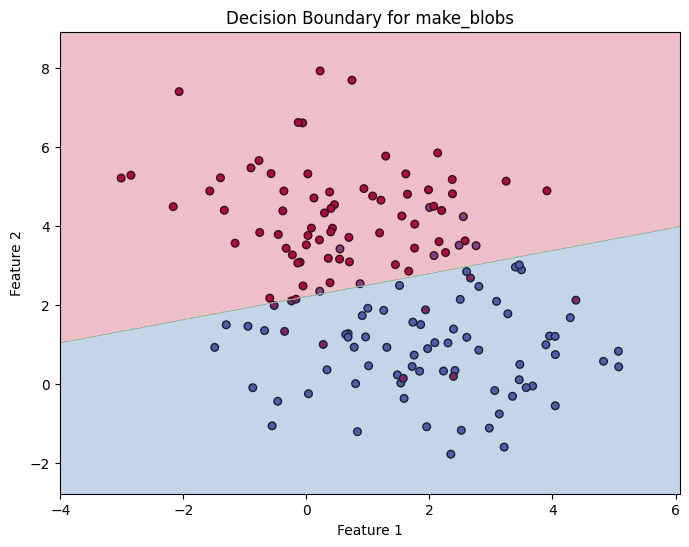

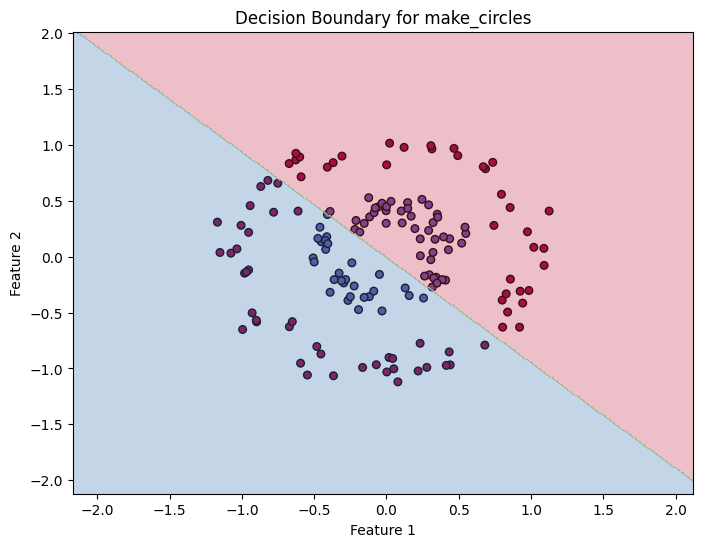

In [20]:
# Visualize the class predictions
def plot_decision_boundary(X, y, learners, title):
    plt.figure(figsize=(8, 6))
    plt.scatter(X[:, 0], X[:, 1], c=y, s=30, cmap=plt.cm.Spectral, edgecolors='k')
    
    # Create a grid to evaluate the model
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.01),
                         np.arange(y_min, y_max, 0.01))
    
    # Predict on the grid
    Z = logitboost_predict(np.c_[xx.ravel(), yy.ravel()], learners)
    Z = Z.reshape(xx.shape)
    
    # Plot decision boundary
    plt.contourf(xx, yy, Z, alpha=0.3, cmap=plt.cm.Spectral)
    plt.title(title)
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.show()

# Plot decision boundaries for both datasets
plot_decision_boundary(X_test1, y_test1, learners1, "Decision Boundary for make_blobs")
plot_decision_boundary(X_test2, y_test2, learners2, "Decision Boundary for make_circles")

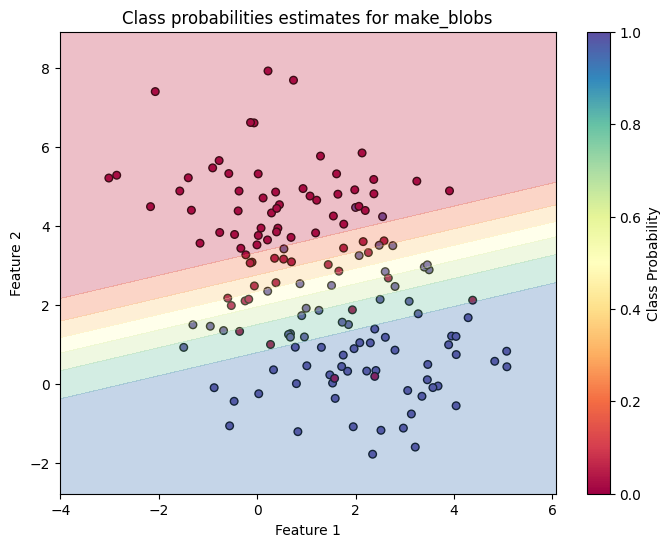

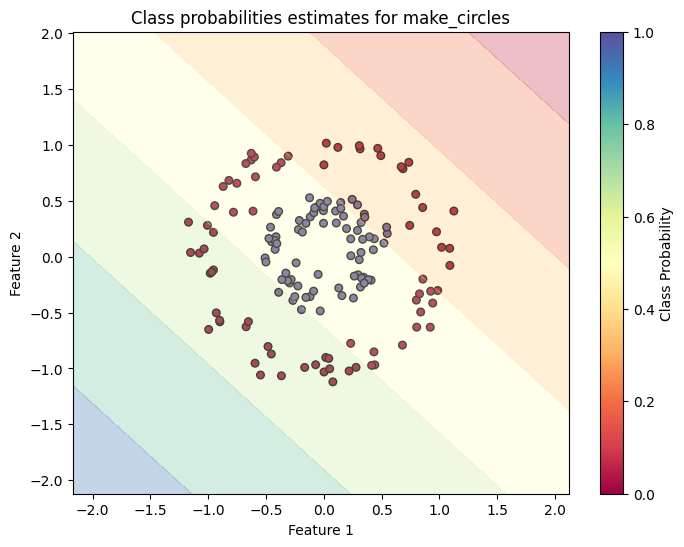

In [9]:
# Visualize the class probabilities
def plot_probabilities(X, y, learners, title):
    # Create a grid to evaluate the model
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.01),
                         np.arange(y_min, y_max, 0.01))
    
    # Predict on the grid
    Z = logitboost_predict(np.c_[xx.ravel(), yy.ravel()], learners, return_proba=True)[1]
    Z = Z.reshape(xx.shape)
    
    # Plot class probabilities
    plt.figure(figsize=(8, 6))
    plt.scatter(X[:, 0], X[:, 1], c=y, s=30, cmap=plt.cm.Spectral, edgecolors='k')
    plt.colorbar(label='Class Probability')
    plt.contourf(xx, yy, Z, alpha=0.3, cmap=plt.cm.Spectral)
    plt.title(title)
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.show()

    # plt.contourf(xx, yy, Z, alpha=0.3, cmap=plt.cm.Spectral)
    # plt.title(title)
    # plt.xlabel('Feature 1')
    # plt.ylabel('Feature 2')
    # plt.show()

# Plot decision boundaries for both datasets
plot_probabilities(X_test1, y_test1, learners1, "Class probabilities estimates for make_blobs")
plot_probabilities(X_test2, y_test2, learners2, "Class probabilities estimates for make_circles")


## For $J$ classes

### Algorithm steps
Having the assumption that $y_{ij}^*$ encode the observed class membership probabilities for instance $x_i$, i.e.,
$$
\begin{equation}
y_{ij}^* = \left\lbrace
\begin{array}{ll}
1 & \text{if } y_i = j\\
0 & \text{if } y_i \neq j\
\end{array}
\right.
\end{equation}
$$ 

(Recall that $y_i$ is the class label example of $x_i$). The $p_j(x)$ are estimates of the class probabilities for an instance $x$ given by the model fit so far. And $z_{ij}$ are "response variables" that encode the error of the currently fit model on the training examples, and then tries to improve the model by adding a function $f_{mj}$ to the committe $F_j$, fit to the response by least-squared error.

Then:

1. Start with weights $w_{ij} = \frac{1}{n}$, for $i=1,...,N$, $j=1,...,J$, $F_j(x)=0$ and $p_j(x)=\frac{1}{J} \text{ } \forall j$.

2. Repeat for $m = 1, ..., M$:
    * Repeat for $j=1, ..., J$:
        1. Compute working responses and weights in the $j$ th class
            $$
                z_{ij} = \frac{y_{ij}^* - p_j(x_i)}{p_j(x_i)(1-p_j(x_i))} \\

                w_{ij} = p_j(x_i)(1-p_j(x_i))
            $$
        2. Fit the function $f_{mj}(x)$ by a weighted least-squares regression of $z_{ij}$ to $x_i$ with weights $w_{ij}$.

    * Set $f_{mj}(x) \leftarrow \frac{J-1}{J}(f_{mj}(x) - \frac{1}{J} \sum_{k=1}^J f_{mk}(x))$, and $F_j \leftarrow F_j(x) + f_{mj}(x)$

    * Update $p_j(x) = \frac{e^{F_j(x)}}{\sum_{k=1}^J e^{F_k(x)}}$

3. Output the classifier $\text{argmax}_j F_j(x)$





We can notice that $\sum_{k=1}^J F_k(x)=0$

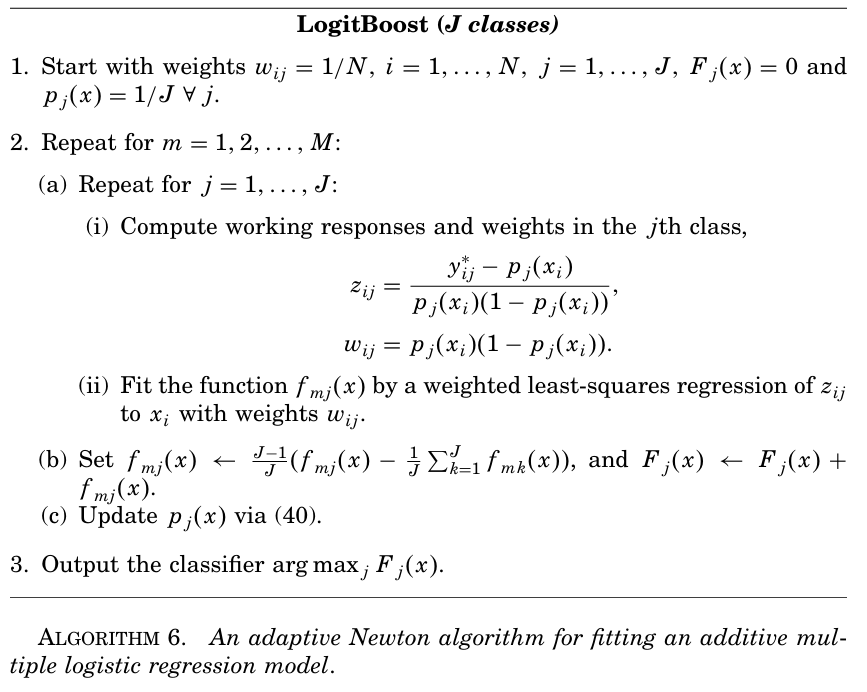

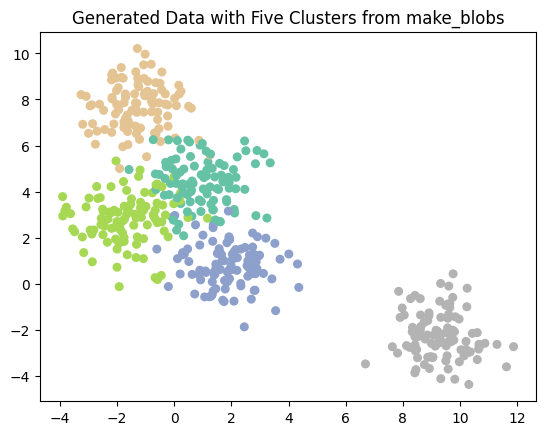

In [10]:
# Generate synthetic data
X,y = make_blobs(n_samples=500, centers=5, cluster_std=1, random_state=0)
plt.scatter(X[:, 0], X[:, 1], s=30, c=y, cmap=plt.cm.Set2)
plt.title("Generated Data with Five Clusters from make_blobs")
plt.show()

In [ ]:
"""
Multiclass LogitBoost
* One-attribute weighted LinearRegression as the weak learner
* Fits and predicts with scikit-learn only for the LR piece

How to use:
learners, J = logitboost_fit(X_train, y_train,
                                     n_estimators=500,
                                     eps=1e-5)

y_hat   = logitboost_predict(X_test,  learners, J)
proba   = logitboost_predict_proba(X_test, learners, J)

"""
# ------------------------------------------------------------------ #
# Auxiliary functions   
# ------------------------------------------------------------------ #

def _softmax(F):
    return np.exp(F) / np.sum(np.exp(F), axis=1, keepdims=True)

def _best_feature_lr(X, z, w):
    """
    Function to return the single feature whose weighted simple (linear) regression gives the smallest 
    weighted sum of square error w·(z − f)^2
    
    Parameters:
    X : array (n_samples, n_features)
    z : array (n_samples,) -- working response
    w : array (n_samples,) -- weights for each sample

    Returns:
    feat_idx : int -- index of the best feature
    intercept : float -- intercept of the best linear regressor
    slope : float -- slope of the best linear regressor
    fitted_values : array (n_samples,) -- predicted values from the best linear regressor
    """
    # Data initialization
    best_err = np.inf
    best_idx = None
    best_b0  = best_b1 = 0.0
    best_fit = None

    # Iterate over each feature
    for k in range(X.shape[1]):
        # Fit a linear regression model to the k-th feature
        # using the working response z and weights w
        lr = LinearRegression()
        lr.fit(X[:, k].reshape(-1, 1), z, sample_weight=w)

        # Predict the fitted values
        f_hat = lr.predict(X[:, k].reshape(-1, 1))
        # Calculate the weighted sum of squared errors
        err   = np.sum(w * (z - f_hat) ** 2)

        # Update the best feature if the current error is lower
        # than the best error found so far
        if err < best_err:
            best_err = err
            best_idx = k
            best_b0  = lr.intercept_
            best_b1  = lr.coef_[0]
            best_fit = f_hat

    return best_idx, best_b0, best_b1, best_fit


# ------------------------------------------------------------------ #
# training                                                           #
# ------------------------------------------------------------------ #
def logitboost_fit(X, y, n_estimators=500, eps=1e-5):
    """
    Function to fit multiclass LogitBoost.
    Parameters:
    X : array (n_samples, n_features)
    y : array (n_samples,) -- int labels in {0, 1, ..., J-1}
    n_estimators : int, number of boosting rounds (M)
    eps : float, lower/upper bound for p so that p∈[eps, 1-eps]

    Returns:
    learners : list of length n_estimators where each element is a list of J tuples (feat_idx, b0, b1)
                where feat_idx is the index of the feature used, b0 is the intercept, and b1 is the slope of the linear regressor
    J : int, number of classes 
    """
    # Data validation and conversion
    X = np.asarray(X, float)
    y = np.asarray(y,  int).ravel()
    n_samples, n_features = X.shape
    J = int(y.max() + 1)

    # Step 1 : Start with weights w_ij = 1/N, F(x) = 0, p_ij = 1/J
    w = np.full(n_samples, 1.0 / n_samples)
    F = np.zeros((n_samples, J))
    p = np.full_like(F, 1.0 / J)
    
    learners = []

    # Step 2 : Iterative boosting
    for m in range(n_estimators):
        # Initialize lists for this round
        round_learners = []        # [(idx,b0,b1)  for j in 0..J-1]
        fits           = []        # list of arrays shape (n_samples,)

        # Step 2.a : Iterate over classes
        for j in range(J):
            # Step 2.a.i : Compute working response and weights for class j
            # y == j  (boolean mask for class j)
            w = np.clip(p[:, j] * (1.0 - p[:, j]), eps, None)  # weights w_ij with numerical safety
            z = ((y == j).astype(float) - p[:, j]) / w             # z_ij

            # Step 2.a.ii : Fit the function f_mj(x) by a weighted least-squares regression of z_ij to x_i with weights w_ij.
            idx, b0, b1, f_hat = _best_feature_lr(X, z, w)

            round_learners.append((idx, b0, b1))
            fits.append(f_hat)

        # Step 2.b : Update of f_mj and F_j(x)
        fits   = np.vstack(fits)  # Outputs of the weak learners, shape J × n_samples
        mean_f = fits.mean(axis=0, keepdims=True) # mean over all classes, shape 1 × n_samples
        adj_f  = (J - 1) / J * (fits - mean_f) # adjust the scores
        F += adj_f.T # F_j(x) = F_j(x) + f_mj(x)

        # Step 2.c : Update p_ij = σ(F_j(x))
        p  = _softmax(F)
        p  = np.clip(p, eps, 1.0 - eps) # numerical safety

        # Store the learners for this round
        learners.append(round_learners)

    return learners, J


# ------------------------------------------------------------------ #
# prediction                                                         #
# ------------------------------------------------------------------ #
def _accumulate_F(X, learners, J):
    """
    Function to compute additive scores  F_j(x)  for every sample.
    Parameters:
    X : array (n_samples, n_features)
    learners : list of length n_estimators
    J : int, number of classes

    Returns:
    F : array (n_samples, J) -- additive scores for each class
    """
    # Data validation and conversion
    X = np.asarray(X, float)
    F = np.zeros((X.shape[0], J))

    # Iterate over learners and accumulate scores
    for round_learners in learners:
        # Each round_learners is a list of tuples (idx, b0, b1) for each class
        fits = []
        # For each learner, compute the fitted values
        for (idx, b0, b1) in round_learners:
            fits.append(b0 + b1 * X[:, idx])
        # Stack the fitted values and compute the mean
        fits   = np.vstack(fits)
        mean_f = fits.mean(axis=0, keepdims=True)
        # Adjust the scores to ensure they sum to zero across classes
        adj_f  = (J - 1) / J * (fits - mean_f)
        # Updtate the additive scores F_j(x) = F_j(x) + f_mj(x)
        F     += adj_f.T
    return F


def logitboost_predict_proba(X, learners, J):
    return _softmax(_accumulate_F(X, learners, J))


def logitboost_predict(X, learners, J):
    # Step 3: Output the classifier argmax_j F_j(x)
    return _accumulate_F(X, learners, J).argmax(axis=1)

    

In [12]:
## Example usage
# Split the dataset into training and testing sets
X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=0.3, random_state=0)
# Fit the LogitBoost model
learners, J = logitboost_fit(X_tr, y_tr, n_estimators=500)
# Predict on the test set
y_hat  = logitboost_predict(X_te, learners, J)
y_prob = logitboost_predict_proba(X_te, learners, J)
# Evaluate the model
print("Accuracy :", accuracy_score(y_te, y_hat))
print("Log-loss :", log_loss(y_te, y_prob))


Accuracy : 0.9266666666666666
Log-loss : 0.19882914967353257


## Comparison against AdaBoost
AdaBoost to additive modeling in statistics. Adaboost works by fitting a base learner to the training data using a vector or matrix of weights. These are then updated by increasing the relative weight assigned to examples that are missclassified at the current round. This forces the learner to focus on the examples that it finds harder to classify. After $T$ iterations the output hypotheses are combined using a series of probabilistic estimates based on their training accuracy.  

**LogitBoost is a boosting classification algorithm. LogitBoost and AdaBoost are close to each other in the sense that both perform an additive logistic regression. The difference is that AdaBoost minimizes the exponential loss:**

$$
 \sum_i \phi (i,y,f) = \sum_i e^{-y_i f(x_i)}
$$

**whereas LogitBoost minimizes the logistic loss or cross entropy:**

$$
 \sum_i \phi (i,y,f) = \sum_i ln(1 + e^{-y_i f(x_i)})
$$

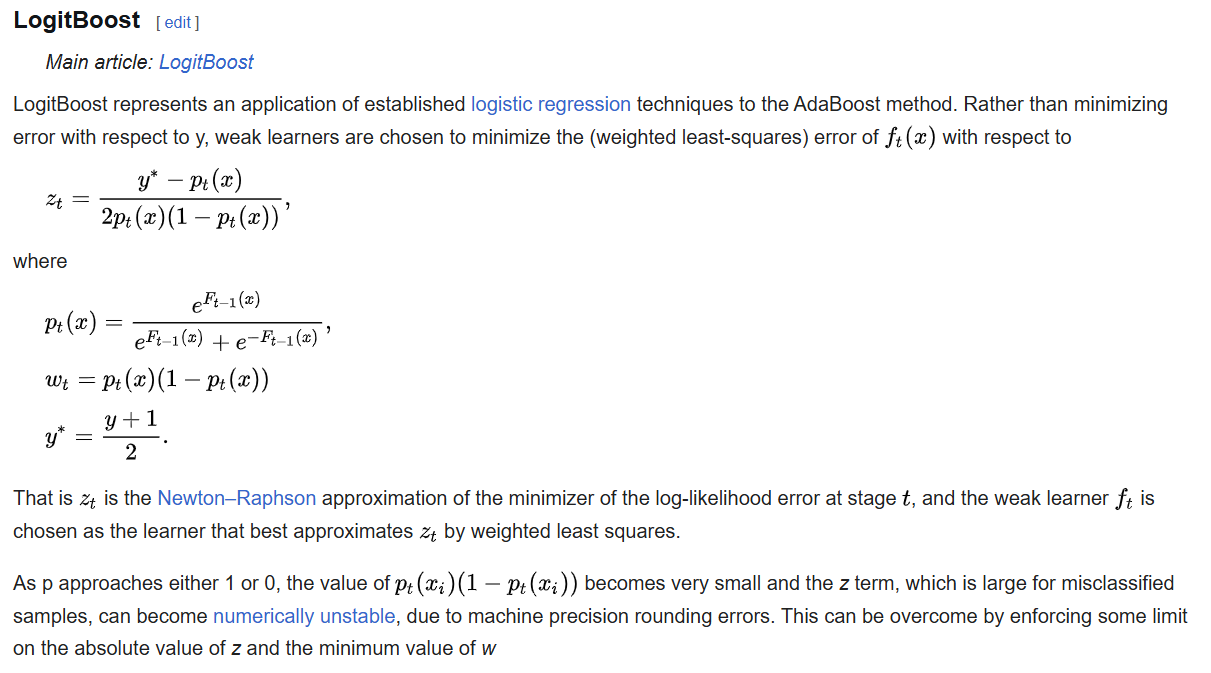

## References
* McDonald, R.A., Hand, J.D, and Eckley, I.A., [An Empirical Comparison of Three Boosting Algorithms on Real Data Sets with Artificial Class Noise](https://www.lancaster.ac.uk/staff/eckley/papers/McDonaldHandEckley2003.pdf), Conference: Multiple Classifier Systems, 4th International Workshop, MCS 2003, Guilford, UK, June 11-13, 2003, Proceedings
* Friedman, J., Hastie, T., Tibshirani, R., [Additive logistic regression: a statistical view of boosting (With discussion and a rejoinder by the authors).](https://projecteuclid.org/journals/annals-of-statistics/volume-28/issue-2/Additive-logistic-regression--a-statistical-view-of-boosting-With/10.1214/aos/1016218223.full) Ann. Statist. 28 (2) 337 - 407, April 2000. https://doi.org/10.1214/aos/1016218223
